# Post procesamiento con pyrsktools

Los pysrktools son un paquete de python para procesar datos de CTD obtenidos con los instrumentos de RBR. Permiten con ellos hacer el procesamiento básico y guardado de datos de manera sencilla. Más información puede ser encontrada en la página de [RBR](https://docs-static.rbr-global.com/pyrsktools/).
Este paquete puede ser instalado usando el siguiente comando en la terminal de anaconda navigator: 

<code>python -m pip install pyrsktools'</code>

Usando un archivo de ejemplo seguiremos los pasos y sus detalles, además del orden de postprocesamiento sugerido por [RBR](https://docs-static.rbr-global.com/pyrsktools/rsk.html).

## Abriendo archivos 

Lo primero que es necesario hacer es abrir los archivos.
Hay varias cosas que se deben revisar antes de comenzar a procesar los datos, una de ellas es identificar la cantidad de perfiles y obtener sus indices.

No se debe olvidar que antes de iniciar con el procesamiento de los datos es necesario cargar todas las librerias que usaremos y añadir el path donde se encuentra nuestro archivo rsk a procesar. Otras maneras de abrir el archivo y trabajar con los datos en python está disponible en la página oficial de [RBR](https://docs-static.rbr-global.com/pyrsktools/guides/post-processing-guide.html).


In [1]:
# agregando librerias a usar
from pyrsktools import RSK
import matplotlib.pyplot as plt
import numpy as np
import os
import processing
from pathlib import Path

# añadiendo el path donde se ubica el archivo rsk
dir='/home/rc/Documents/OneDrive-UdeC/TRABAJOS_INDEPENDIENTES/COPAS_Diego_Narváez/TORTEL_hr/Horarios_Abr2024/'
name='CTD Bahia de Tortel 19 de Abril  1200 Hrs de 2024_upgraded.rsk'
path = dir+name
#path= '/home/rc/Downloads/sample.rsk'

# abriendo el archivo con los pyrsktools
rsk = RSK(path) # la funcion RSK permite interactuar con el conjunto de datos producido por el instrumento
rsk.open()
rsk.readdata()
raw = rsk.copy()
raw.computeprofiles()
upcastIndices = raw.getprofilesindices(direction="up") 
downcastIndices = raw.getprofilesindices(direction="down")
raw.deriveseapressure()

Ruskin profile and cast annotations will be deleted as they might conflict with the new profiles detected


### Opcionales de las funciones usadas hasta aquí

### [open:](https://docs-static.rbr-global.com/pyrsktools/_rsk/read.html#pyrsktools.RSK.open)
Abre los archivos rsk y lee cualquier metadato disponible.</p>

Ejemplo 1:

<code>rsk = RSK("example.rsk", readHiddenChannels=True)
   rsk.open()</code>
        
Ejemplo 2:

<code>with RSK("example.rsk") as rsk:
    # RSK is open here</code>

### [readdata:](https://docs-static.rbr-global.com/pyrsktools/_rsk/read.html#pyrsktools.RSK.readdata)
Extrae los valores de los datos en el archivo rsk y llena la el parámetro rsk.data del archivo. Si este parámetro ya contenía datos estos serán reemplazados por los nuevos valores. Los opcionales son usados principalmente para leer una subsección específica del archivo. Los valores ingresados son fechas con formato NumPY.

Opcionales: 

  t1: tiempo de inicio. None (default)
  
  t2: tiempo final. None (default)</p>
  
Ejemplo:

<code>rsk.readdata()
        # Optional arguments
        tstart = np.datetime64("2022-05-03")
        tend = np.datetime64("2022-05-04")
        rsk.readdata(tstart, tend) </code>

### [copy:](https://docs-static.rbr-global.com/pyrsktools/_rsk/other.html#pyrsktools.RSK.copy)
Crea una copia completa del archivo rsk abierto. Esta nueva copia contiene exactamente los mismos datos y es completamente independiente del original. Se utiliza principalmente para que los datos originales no sean afectados en caso de que se requiera realizar alguna corrección en el post-procesamiento de los datos. Este paso es importante realizarlo antes de derivar cualquier variable para que así el archivo orgininal se mantenga sin variaciones.</p>

### [computeprofiles:](https://docs-static.rbr-global.com/pyrsktools/_rsk/read.html#pyrsktools.RSK.computeprofiles)
Detecta los perfiles usando el canal de presión y llena el "RSK.regions" con la metadata producida. Registra los perfiles en una serie de tiempo usando datos de presión y conductividad. El límite de presión de 3dbar puede ser muy grande para perfiles cortos por lo que se recomienda usar 1/4 del rango de presión como guía. Esto es (max(Pressure) - min(Pressure)) * 1/4.

Opcionales:
    
pressureThreshold: 3.0 (default)

conductivityThreshold: 0.05 (default)

Ejemplo:

<code>rsk.computeprofiles()
        # Optional arguments
        rsk.computeprofiles(pressureThreshold=5.0, conductivityThreshold=0.06)</code>
        
### [getprofileindices:](https://docs-static.rbr-global.com/pyrsktools/_rsk/read.html#pyrsktools.RSK.getprofilesindices)
Obtiene una lista de índices de cada perfil o dirección de cast y los guarda dentro de "RSK.data"

Opcionales:

profiles: número de perfiles. [] (default). Si nada se ingresa se obtienen todos los perfiles

direction: dirección del cast. 'up', 'down', 'both' (default)</p>

Ejemplo:

<code>       profileIndices = rsk.getprofilesindices()
        upcastIndices = rsk.getprofilesindices(direction="up")
        firstDowncastIndices = rsk.getprofilesindices(profiles=1, direction="down")</code>

### [deriveseapressure:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#deriveseapressure)
Calcula la presión del mar a partir de la presión y la presión atmosférica. Su resultado es agregado al "RSK.data" y el metadata en "RSK.channels" se actualiza agregando esta nueva variable. Se puede personalizar patm, sin embargo, el valor por defecto se rescata el valor desde los parámetros o se asume que es 10.1325 dbar. 

Opcionales:
    
patm: presión atmosférica. None (default) </p>

Ejemplo: 

<code>rsk.deriveseapressure()
    # Optional arguments
    rsk.deriveseapressure(patm=10.1)</code>

## Post-procesamiento de los datos

Ahora que ya hemos derivado nuestra primera variable podemos revisar la lista de canales disponibles con la función 'printchannels'. Adicionalmente también podemos graficar cualquiera de las variables que están disponibles en la base de datos. En las siguientes celdas se muestran en orden los pasos a seguir para el post-procesamiento de datos, junto con una breve descripción, parámetros de ingreso y ejemplos. Luego de cada paso se realizará un gráfico para ir viendo las variaciones en los datos. Usando la función "printchannels" podemos ver algunos datos preliminares del instrumento. Por ejemplo, en este caso el periodo de muestreo es de 0.167 segundos. 

Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

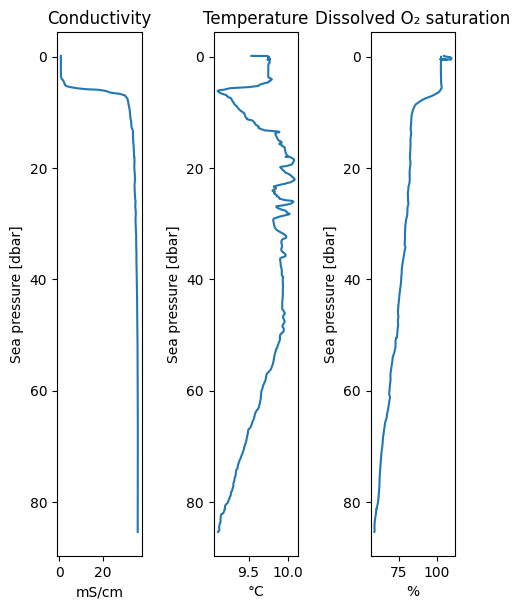

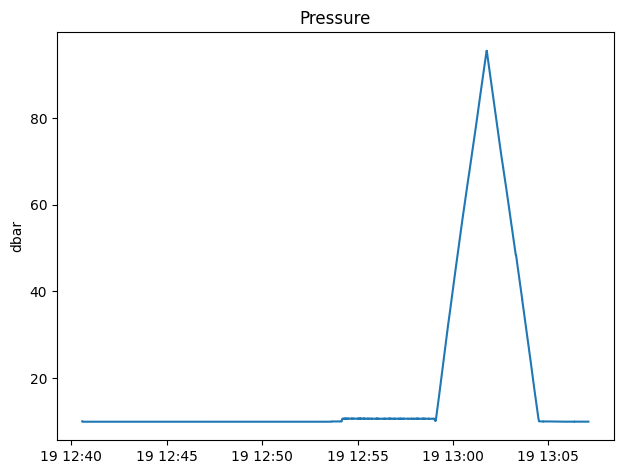

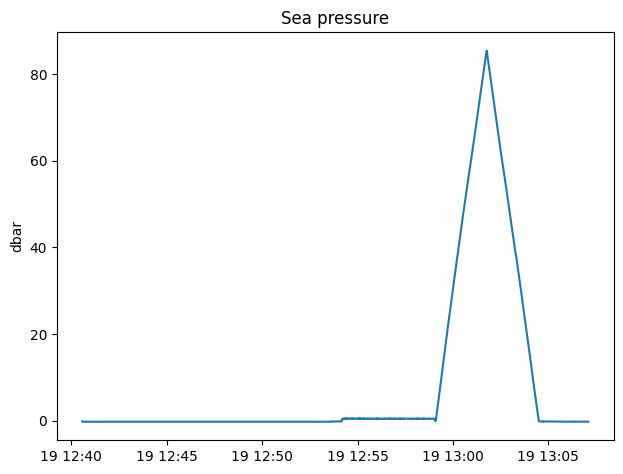

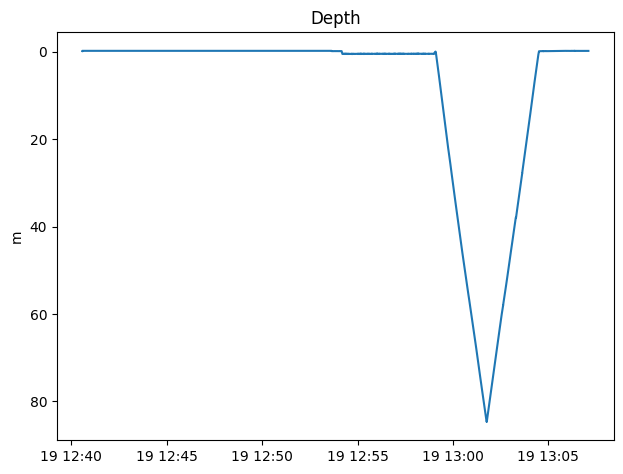

In [2]:
raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")


Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

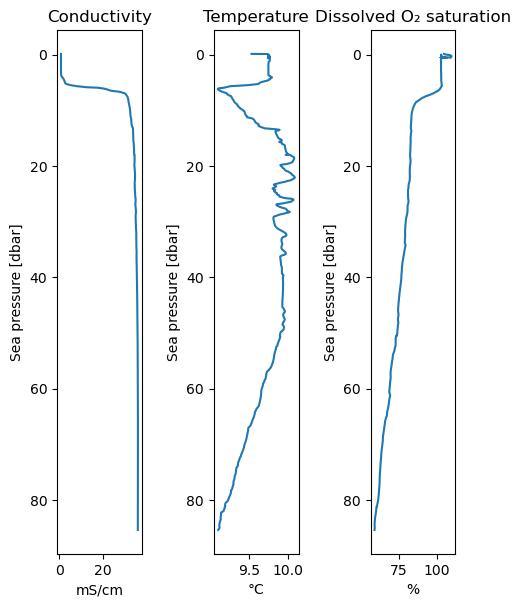

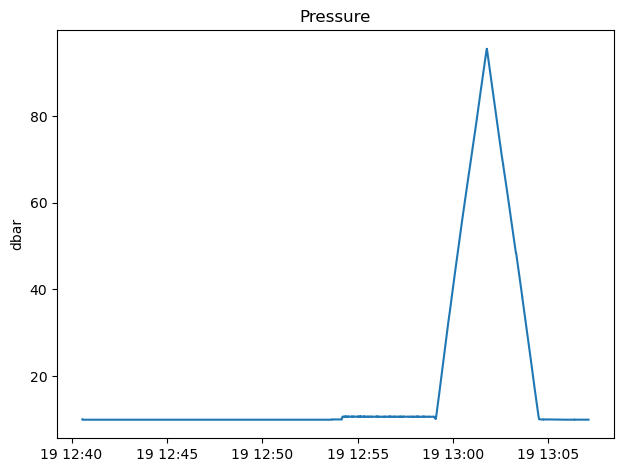

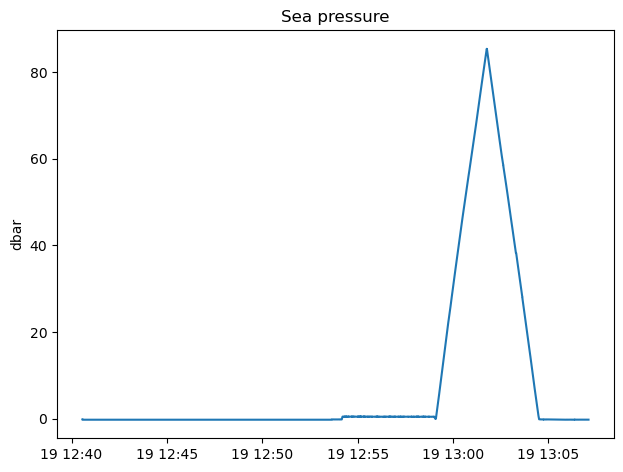

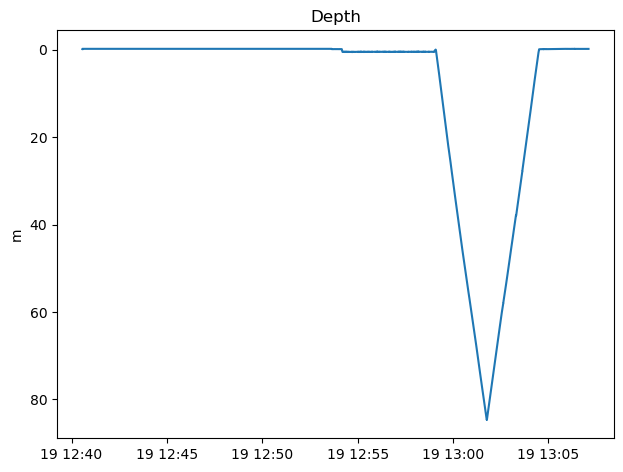

In [5]:
raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")


Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

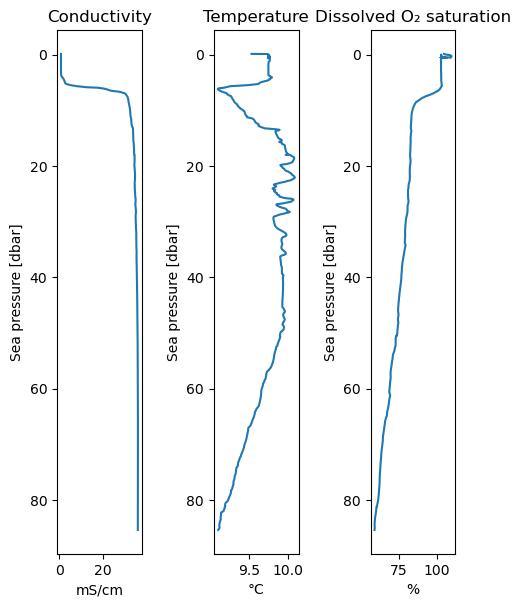

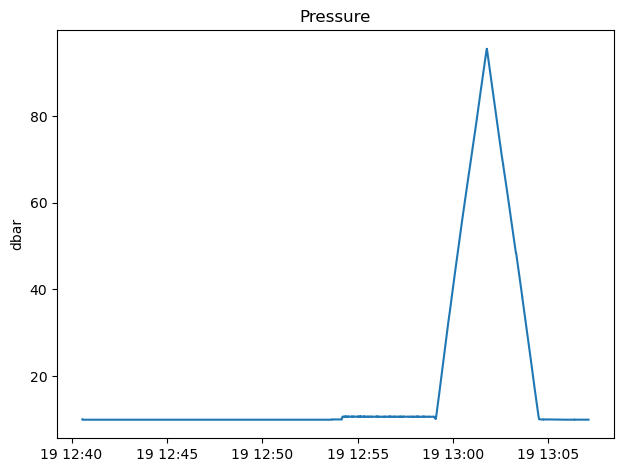

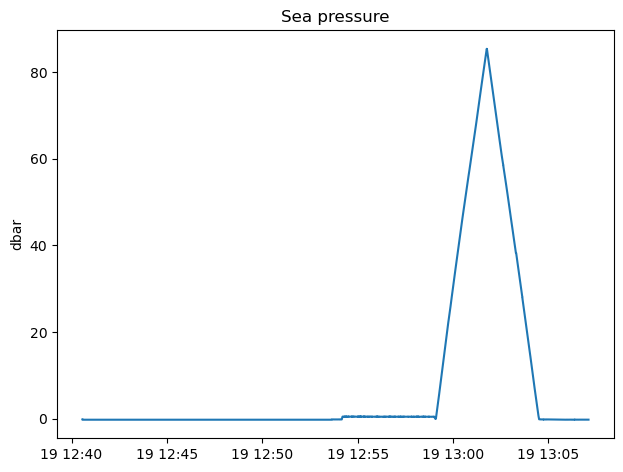

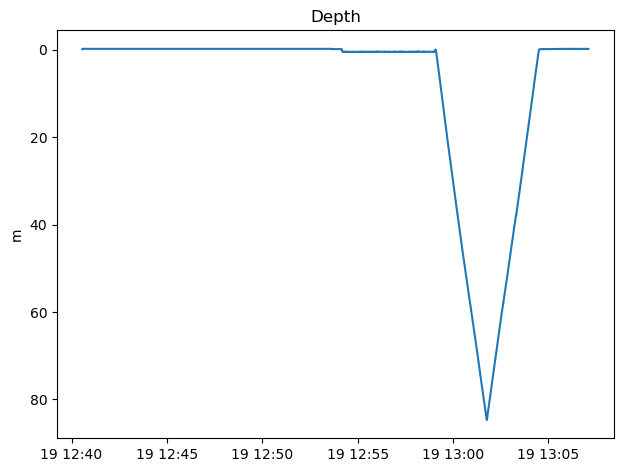

In [7]:
dir = 'up'
# Corrección de orden cero
raw.correcthold(action = "interp")

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [correcthold:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#correcthold)
Es la correción para retención de orden cero del convertidor analógico a digital (A2D). En el tiempo que se toma para calibrar el equipo hay muestras/datos que se pierden. Se usa la retención de orden cero para llenar estos datos perdidos con los mismos datos medidos durante la muestra anterior. En este paso se identifican los puntos de retenciones de orden cero al encontrar dónde las diferencias consecutivas de cada canal son iguales a 0 y luego las reemplaza por nan o las interpola.

Opcionales:

  channels: canal a procesar. [] (default)
  
  profiles: número de perfiles. [] (default)
  
  direction: dirección del cast. 'up', 'down', 'both' (default)
  
  action: acción a realizar. 'nan' (default), 'interp'

  Ejemplo:
  
  <code>rsk.correcthold()</code>
  

Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

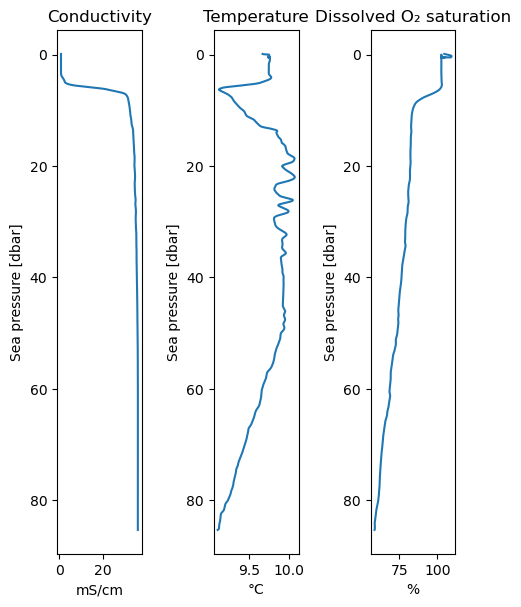

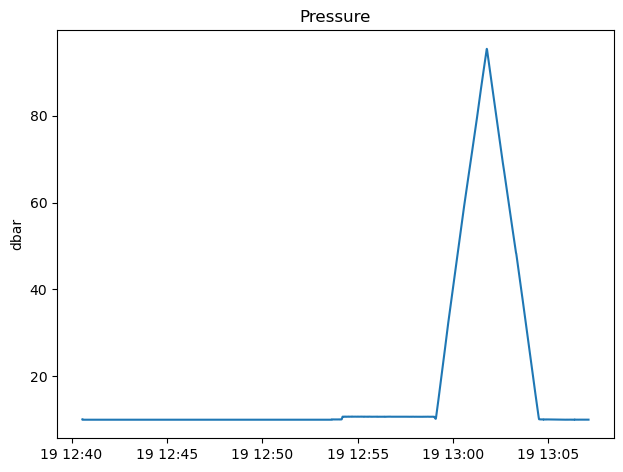

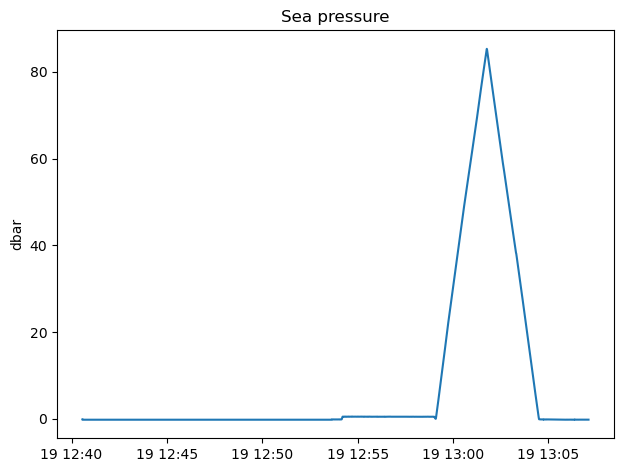

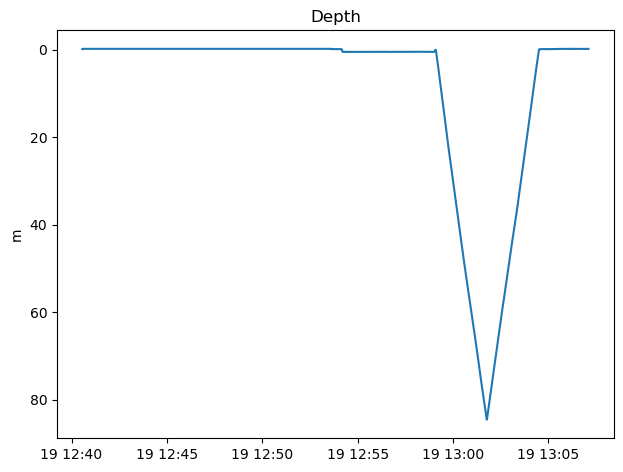

In [9]:
# Filtro pasa bajo
raw.scheduleInfo.samplingperiod()
raw.smooth(channels = [], windowLength = 7)

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [smooth:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#smooth)
Es un filtro pasa bajo usado para reducir el ruido y hacer coincidir las constantes de tiempo del sensior debido a que variables como temperatura (100 ms) y conductividad tienen tiempos de muestreo diferentes. El muestreo de las variables se puede obtener a partir de la función scheduleinfo. La muestra que se evalúa siempre está en el centro de la ventana de filtrado para evitar distorsión, los efectos de borde se manejan reflejando la serie temporal original. El filtro mediano es menos sensible a los valores extremos, los otros dos son mas efectivos para reducir y suavizar ruido.

Opcionales:

channels: nombre de variable a filtrar o lista de ellos

filter: tipo de filtro. "boxcar" (default), "triangle", "median"

profiles: cantidad de perfiles. [] (default)

direction: "up", "down", "both" (default)

windowlength: el tamaño total de la ventana del filtro, debe ser entero impar. 3 (default)

Ejemplo:

<code>rsk.smooth(channels = ["salinity"], windowLength = 5)
rsk.smooth(channels=["temperature", "salinity"], windowLength=17)<code>


<p>- scheduleInfo.samplingperiod(): usado para conocer la tasa de muestreo de las variables.</p>


the lag is: -3.0
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity        

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

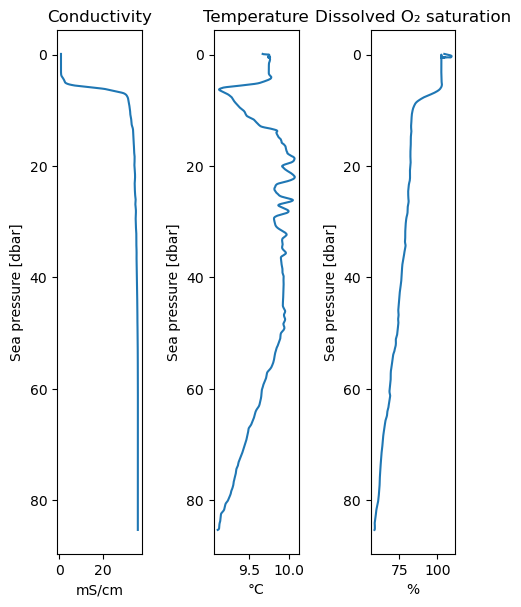

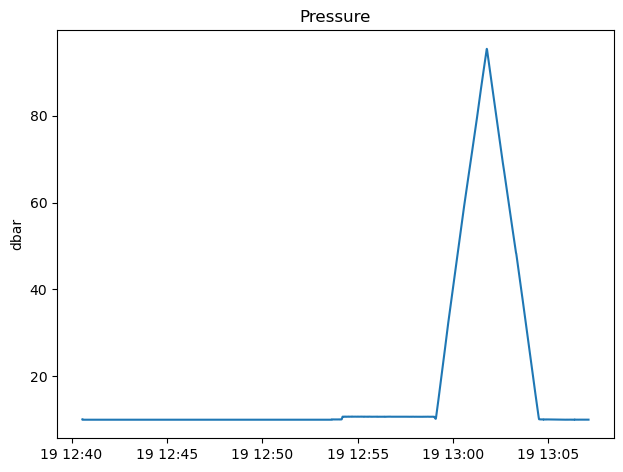

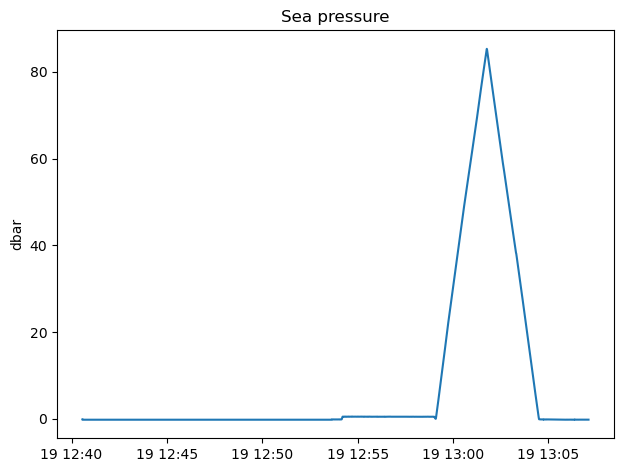

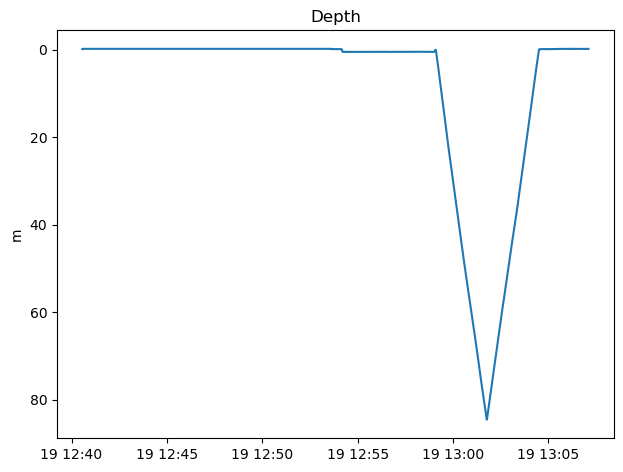

In [11]:
# Alineación de temperatura y conductividad
lag = raw.calculateCTlag(seapressureRange = (3,round(max(raw.data["sea_pressure"]),0)), direction = dir) 
# Advance temperature
lag = -np.array(lag)
# Select best lag for consistency among profiles
lag = np.median(lag)
print("the lag is: "+str(lag))
raw.alignchannel(channel = "temperature", lag = lag, direction = dir)

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [calculateCTlag:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#calculatectlag)
Se utiliza para alinear temperatura y conductividad. En condiciones dinámicas y según la posición del sension en el CTD los sensores de temperatura y conductividad miden porciones de agua ligeramente diferentes. Además, sensores como el oxígeno, que contienen constantes de tiempo larga puede retrasar la medición con respecto al valor real. La solución es adelantar en el tiempo los datos del sensor. Si temperatura y salinidad no están alineadas habrá peaks de salinidad en interfaces agudas y un sesgo continuo en entornos estratificados. Para solucionar esto se calcula y grafica para la salinidad un rango de desfase y se elige aquel con los peaks de salinidad más pequeños en interfaces de temperatura agudas. Para ello se calcula incialmente el lag con esta función y de acuerdo a su media se alinean las variables.

Opcionales:

seapressureRange: rango de presiones a alinear. [seapressureMin,seapressureMax], None (default) el argumento será (0,max(seapressure))

profiles: cantidad de perfiles. [] (default), es decir, todos

direction: dirección del cast. up, down, both (default)

windowlength: largo de la ventana a usar. 21 (default)

Ejemplo:

<code>lag=rsk.calculateCTlag(seapressureRange = (1,50), direction = "down")</code>


### [alignchannel:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#alignchannel)
Se utiliza para alinear los canales de temperatura y salinidad para obtener valores más preciso.

Opcionales:

channel: canal a trabajar

lag: numero decimal, float. 

profiles: perfiles a trabajar. [] (default), es decir, todos

direction: dirección del cast.  up, down, both (default)

shiftfill: shift fill treatment. zeroorderhold (default), nan, or mirror

lagunits: unidades de lag. samples (default), seconds.

Ejemplo:

<code>rsk.alignchannel(channel = "temperature", lag = lag, direction = "down")</code>

<p>Si ya se había calculado la salinidad anteriormente, será necesario volver a calcularla usando: </p>

<code>rsk.derivesalinity()</code>

<p> Ejemplo global:</p>

<code>     with RSK("example.rsk") as rsk:
    rsk.computeprofiles(profile=range(0,9), direction="down")
    # 1. Shift temperature channel of the first four profiles with the same lag value.
    rsk.alignchannel(channel="temperature", lag=2, profiles=range(0,3))
    # 2. Shift oxygen channel of first 4 profiles with profile-specific lags.
    rsk.alignchannel(channel="dissolved_o2_concentration", lag=[2,1,-1,0], profiles=range(0,3))
    # 3. Shift conductivity channel from all downcasts with optimal lag calculated with calculateCTlag().
    lag = rsk.calculateCTlag()
    rsk.alignchannel(channel="conductivity", lag=lag) </code>
    
### [derivesalinity:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivesalinity)
Calcula la salinidad a partir de la conductividad, temperatura y la presión del mar usando la funcion gsw_SP_from_C de TEOS-10.

Opcionales:

seawaterLibrary: que libreria utilizará. El soporte incluye TEOS-10. TEOS-10 (default)

Ejemplo:   

<code>rsk.derivesalinity()
    # Optional arguments
    rsk.derivesalinity(seawaterLibrary="TEOS-10")</code>

Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

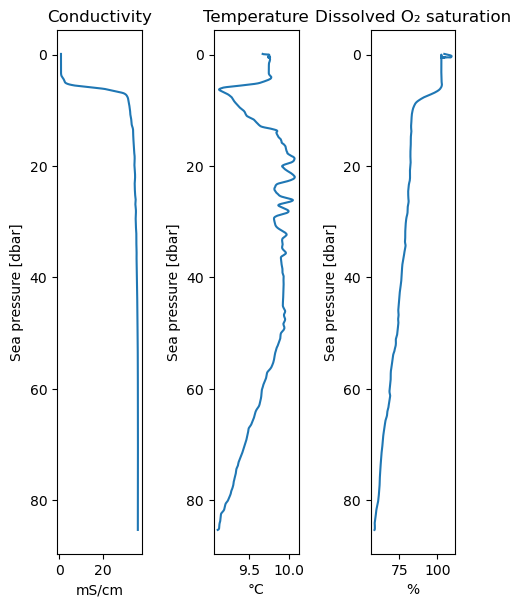

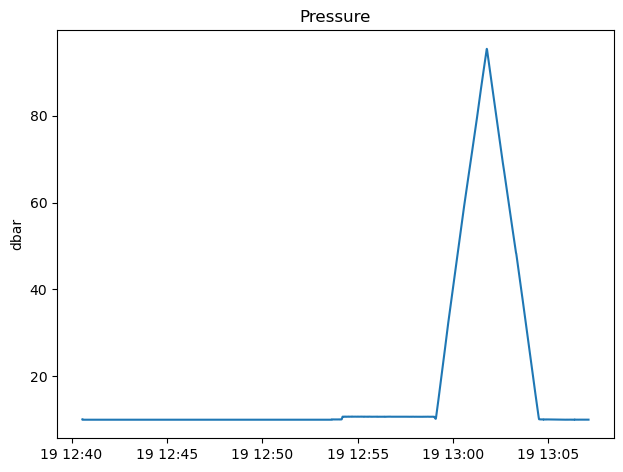

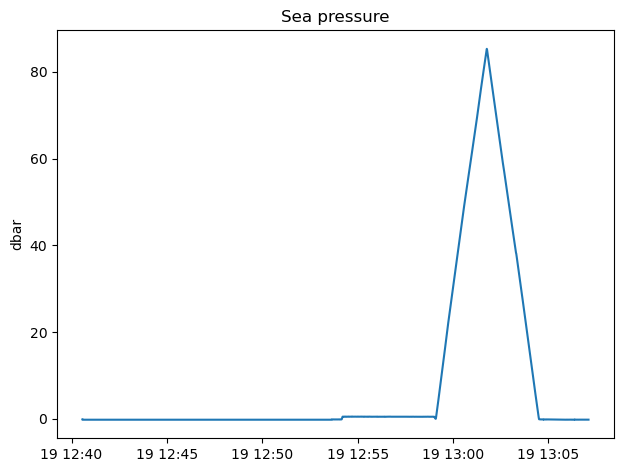

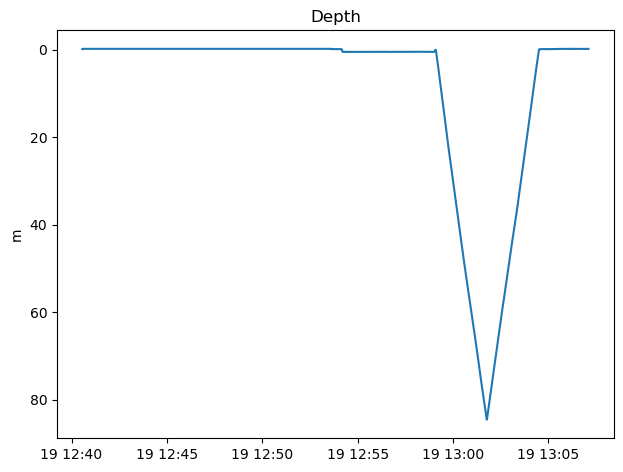

In [13]:
#Corrección de tau
raw.correcttau(channel="dissolved_o2_saturation", tauResponse=2, direction=dir, profiles=[])  #rinko 3. 

#Corrección de conductividad térmica
raw.correctTM(alpha=0.04, beta=0.1)

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [correcttau:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#correcttau)
La corrección de tau debido a que los sensores requieren cierto tiempo de estabilizacion, por ello, se pueden ver alteradas las magnitudes y fases de la señal verdadera captada por el instrumento. Este metodo utiliza el metodo de Fozdar para corregir la fase y la respuesta de una señal medida para representar de manera mas precisa la señal. Para el sensor de oxígeno disuelto el tiempo de respuesta es de 10 s aproximadamente, mientras que para el sensor óptico de oxígeno disuelto el tiempo de respuesta va desde <1s hasta <30s. El estándar en este último caso es de 8s aprox.

Opcionales:

channel: canal a corregir.

tauResponse: constante de tiempo del sensor del canal respectivo, en segundos.

tauSmooth: escala de tiempo de suavizado en segundos. 0 (default)

profiles: cantidad de perfiles a trabajar. [] (default)

direction: dirección del cast. up, down, both (default)

Ejemplo:
<code>rsk.correcttau(channel="dissolved_o2_saturation", tauResponse=8, direction="down", profiles=1) </code>

### [correctTM:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#correcttm)
La correccion de conductividad termica se realiza usando el modelo de Lueck y Picklo (1990). Es usada para minizar los efectos de la celda de conductividad de masa termica en la conductividad medida. Las celdas de conductividad cambian calor con el agua a medida que pasan por gradientes de temperatura. El calor transferido cambia la temperatura del agua y por lo tanto la conductividad medida. Este efecto impacta en la salidad y densidad derivada en forma de spikes afilados e incluso a bias bajo ciertas condiciones.

Opcionales:

alpha: magnitud inicial de la anomalia termal del fluido

beta: tiempo de relajacion inversa del ajuste

gamma: coeficiente de conductividad de temperatura. 1 (default)

profile: perfiles a trabajar. [] (default)

direction: direccion del cast. up, down, both (default)

Ejemplo:

<code> rsk.correctTM(alpha=0.04, beta=0.1)</code>
   
* No olvidar re-calcular la salinidad luego de corregir la conductividad térmica.

Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
                 8         velocity                        m/s
Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
 

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

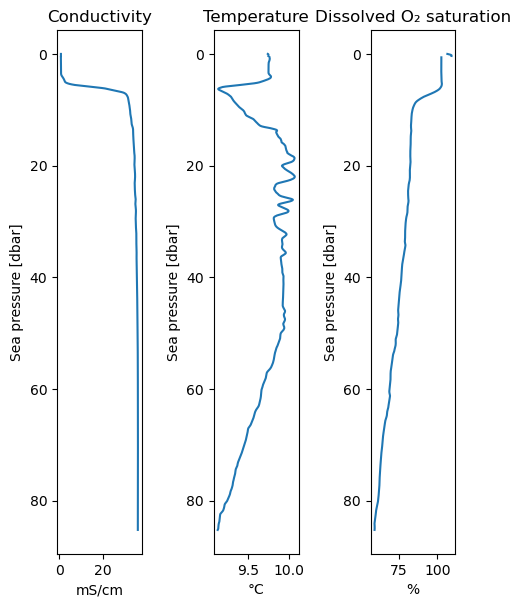

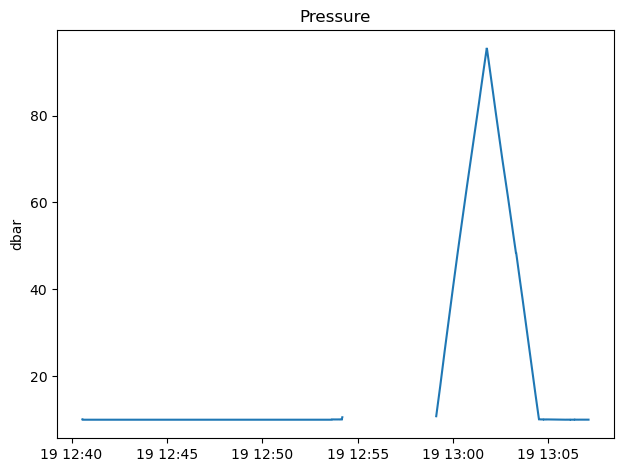

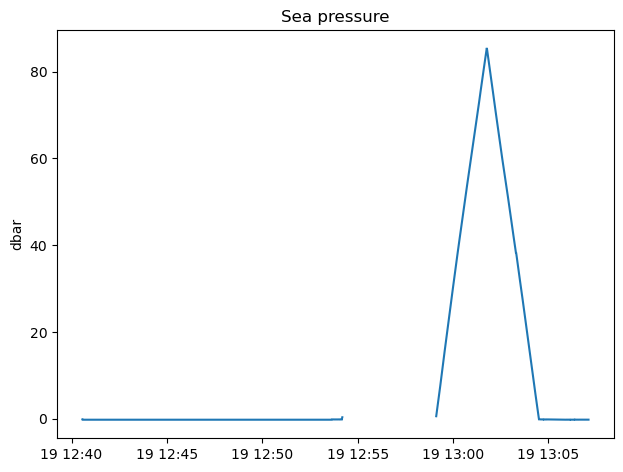

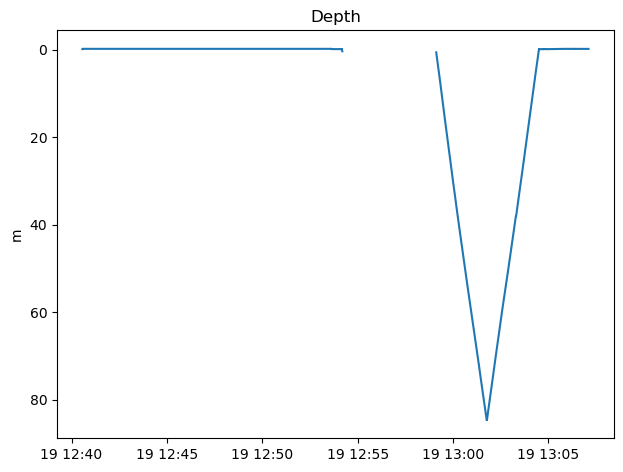

In [15]:
#Eliminar loops
raw.deriveseapressure()
rsk.deriveseapressure()
raw.derivedepth()
raw.derivevelocity()
raw.removeloops(threshold = 0.25) 

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [removeloops:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#removeloops)
Se utiliza principalmente para corregir los datos cuando el instrumento baja demasiado lento o durante un cambio de presión. Esto es útil principalmente en regiones con un gradiente fuerte para mantener una buena calidad de datos. Generalmente los datos tomados cuando se está midiento lentamente cerca de la superficie son removidos. Para llevarlo a cabo pasos previos deben ser realizados.

Opcionales:

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. up, down, both (default)

threshold: minima velocidad a la que el perfil debe ser tomado en m/s. 0.25 (default)

Ejemplo:

<code> rsk = RSK.removeloops(threshold = 0.3)</code>

### [derivedepth:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivedepth)
Se calcula la profundidad a partir de la presión. Si ya se calculó antes, la variable se sobreescribe.

Opcionales:

latitude: latitud de la medida de presion en grado decimal. 45.0 (default)

seawaterLibrary: libreria que utilizará el método. TEOS-10 (default) y unica soportada de momento.

Ejemplo:

<code>    rsk.derivedepth()
    # Optional arguments
    rsk.derivedepth(latitude=45.34, seawaterLibrary="TEOS-10")</code>

### [derivevelocity:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivevelocity)
Calcula la velocidad a la que fue tomado el perfil utilizando los canales de profundidad y tiempo. 

Opcionales:

windowLength: tamaño de la ventana del filtro usado para la salinidad de referencia. 3 (default)

Ejemplo:

<code>   rsk.derivevelocity()
    # Optional arguments
    rsk.derivevelocity(windowLength=5)</code>


{numpy.datetime64('2025-04-03T18:15:59.525'): '/home/rc/Documents/OneDrive-UdeC/TRABAJOS_INDEPENDIENTES/COPAS_Diego_Narváez/TORTEL_hr/Horarios_Abr2024/CTD Bahia de Tortel 19 de Abril  1200 Hrs de 2024_upgraded.rsk opened using pyRSKtools v1.1.1.', numpy.datetime64('2025-04-03T18:15:59.582'): 'Sea pressure calculated using an atmospheric pressure of 10.1325 dbar.', numpy.datetime64('2025-04-03T18:16:01.605'): 'Depth calculated using the TEOS-10 library and a latitude of 45.0 degrees', numpy.datetime64('2025-04-03T18:16:08.212'): 'Depth calculated using the TEOS-10 library and a latitude of 45.0 degrees', numpy.datetime64('2025-04-03T18:16:23.190'): 'Zero-order hold corrected for channel(s) conductivity, temperature, pressure, dissolved_o2_saturation, chlorophyll, turbidity, sea_pressure, depth. Hold points were treated with interp.', numpy.datetime64('2025-04-03T18:16:23.306'): 'Depth calculated using the TEOS-10 library and a latitude of 45.0 degrees', numpy.datetime64('2025-04-03T18:1

(<Figure size 640x480 with 1 Axes>,
 [<Axes: title={'center': 'Depth'}, ylabel='m'>])

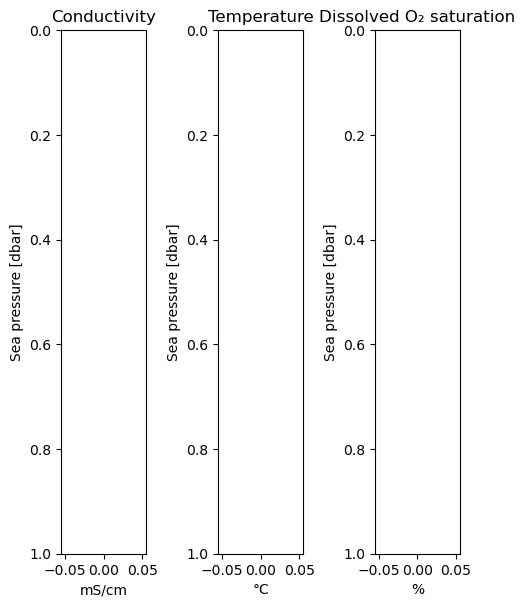

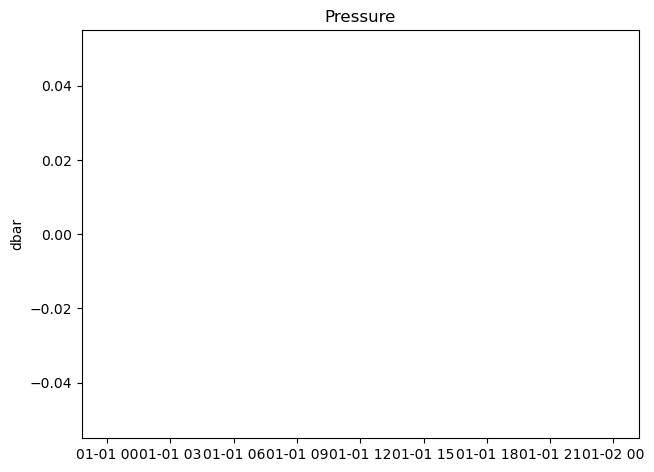

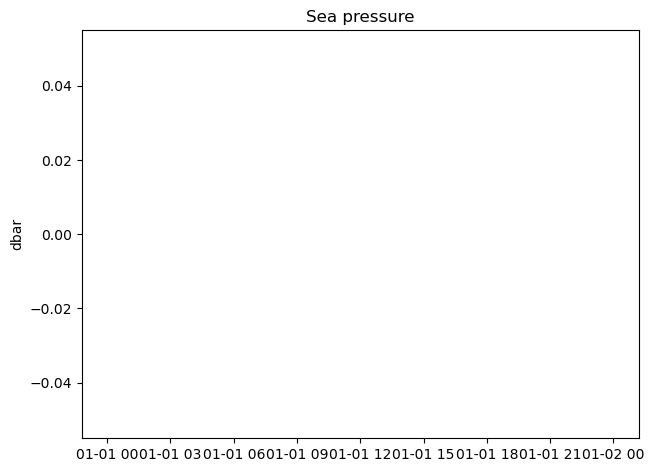

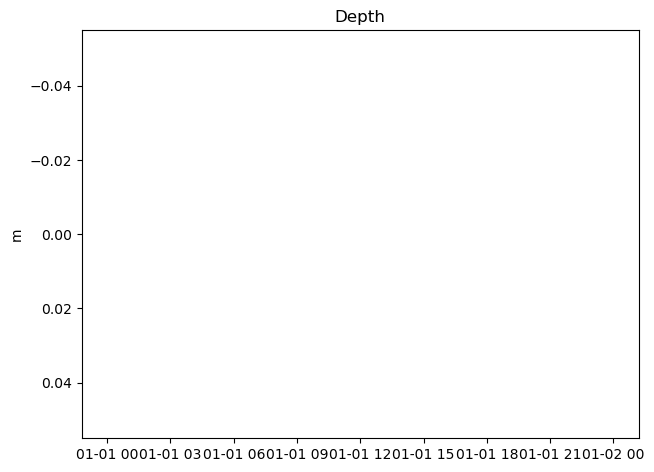

In [25]:
# Bin average
raw.binaverage(
    binBy = "depth",
    binSize = 1.5,#[1,5],
    boundary = [1, 20], 
    direction = dir
)

print(raw.logs)

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

### [binaverage:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#binaverage)
Sirve para promediar las variables a la misma profundidad. El promedio de bin reduce el ruido del sensor y se asegura que los perfiles están referenciados a una grilla común lo cual puede ser usado para graficar heatmaps (mapas de calor). Se puede hacer de acuerdo a cualquier referencia (tiempo, profundidad, presion del mar, etc). Se puede promediar con respecto a tamaños de bin variables a lo largo de la columna de agua. Si la dirección escogida es up el primer limite y el binSize estan mas cerca del fondo con los siguientes limites en orden desendiente.

Opcionales:

profiles: perfiles a trabajar. None (default)

direction: dirección del cast. up, down, both (default)

binBy: canal de referencia para determinar la muestra en cada bin. Puede ser timestamp o cualquier canal. sea_pressure (default)

binSize: tamaño del bin. 1 (default). La unidad es la misma que el canal de referencia escogido

bondary: es el primer limite cruzado en la direccion escogida para cada regimen, en las mismas unidades que binBy. Debe tener el mismo tamaño que binSize o uno más. [] (default), es decir, todo el rango

Ejemplo1:

<code>rsk.binaverage(
       binBy= "sea_pressure",
       binSize = 0.25,
       boundary = [0.5, 5.5],
       direction = "up"
   );</code>

<p>Ejemplo2:</p>

<code>rsk.binaverage(direction="down", binSize=1.0, boundary=0.5)</code>

<p>Ejemplo3:</p>

<code>samplesinbin = rsk.binaverage(direction="down", binBy="Depth", binSize=[10.0, 50.0], boundary=[10.0, 50.0, 200.0])</code>

Todo el procesamiento puede ser desplegado usando:  <code>print(rsk.logs)</code>

Model:           RBRconcerto
Serial ID:       80257
Sampling period: 0.167 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         conductivity                    mS/cm
                 1         temperature                     °C
                 2         pressure                        dbar
                 3         dissolved_o2_saturation         %
                 4         chlorophyll                     µg/l
                 5         turbidity                       NTU
                 6         sea_pressure                    dbar
                 7         depth                           m
                 8         velocity                        m/s
                 9         salinity                        PSU
                 10        density_anomaly                 kg/m³
                 11        absolute_salinity               g/kg
Model:           RBRconce

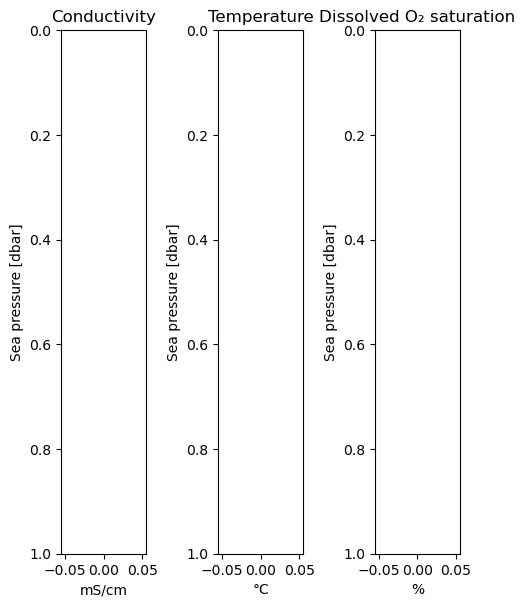

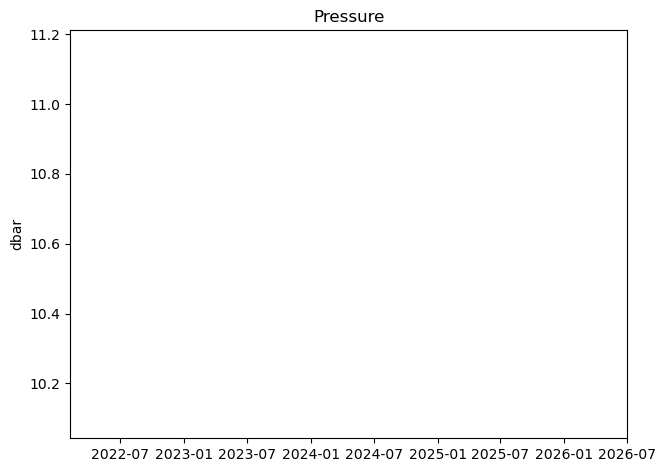

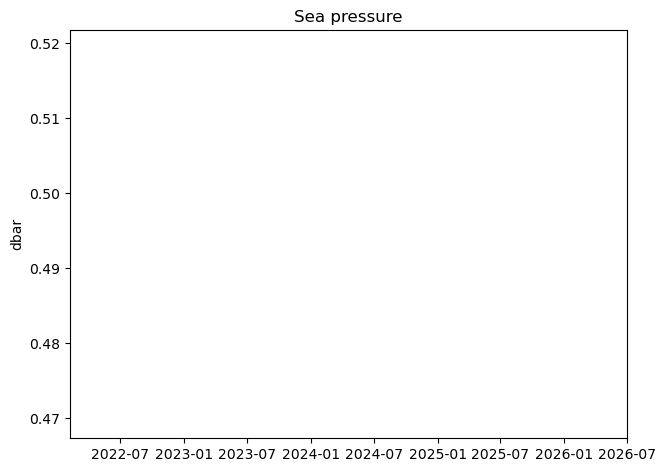

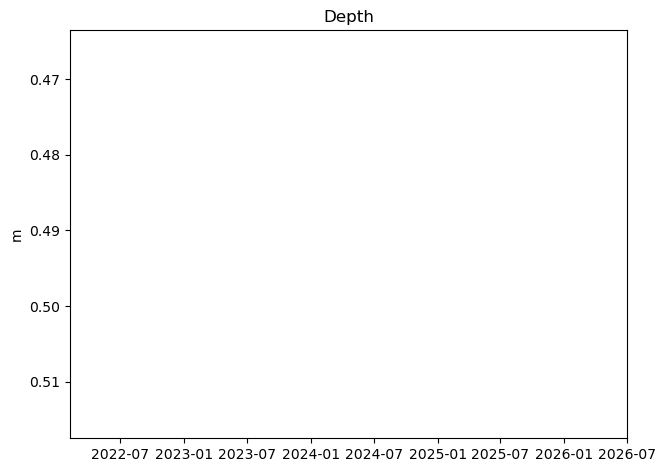

In [23]:
# Derivación de otras variables
raw.derivesalinity()
raw.derivesigma()
#raw.derivebuoyancy()
raw.deriveSA()

raw.printchannels()
rsk.printchannels()
#raw.plotprofiles(channels = 'conductivity',direction="up")
raw.plotprofiles(channels = ['conductivity','temperature','dissolved_o2_saturation'],direction="down")
raw.plotdata(channels = ['pressure'],direction="up")
raw.plotdata(channels = ['sea_pressure'],direction="up")
raw.derivedepth()
raw.plotdata(channels = ['depth'],direction="up")

raw.RSK2CSV(channels = [], profiles= [],outputDir= '.',comment= "processed data")


## Otras variables derivadas

### [derivesigma](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivesigma): 
Calcula la anomalia de densidad potencial. Para usarla antes se debe calcular la salinidad absoluta, la temperatura potencial y la anomalia de densidad potencial.
    
SA = gsw_SA_from_SP(salinity,seapressure,lon,lat)

pt0 = gsw_pt0_from_t(absolute salinity,temperature,seapressure)

sigma0 = gsw_sigma0_pt0_exact(absolute salinity,potential temperature)

Opcionales:

latitud: en grados norte decimal. None (default)

longitud: en grados este decimal. None (default)

seawaterLibrary: libreria a utilizar. TEOS-10 (default)

Ejemplo:</p>

<code>rsk.derivesigma()
    # Optional arguments
    rsk.derivesigma(latitude=45.34, longitude=-75.91)</code>

<p>Hay otras variables que pueden ser derivadas, estas serán listadas a continuación, sin embargo no entraremos en mayor detalle:
    
- [deriveC25](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivec25)
  
- [deriveBPR](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivebpr)
  
- [deriveO2](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#deriveo2)
  
- [derivebuoyancy](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivebuoyancy)

- [deriveSA](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivesa)

- [derivetheta](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivetheta)

- [derivesoundspeed](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivesoundspeed)

- [deriveA0A](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#derivea0a)

- [deriveAPT](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#deriveapt)

  Mayor informacion se puede encontrar en el [sitio oficial de RBR](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html)</p>

rsk.close()

 ## Otras correcciones
### [despike:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#despike) 
Se usa para remover los spikes de acuerdo a un limite de cierta cantidad de desviaciones estandar. El algoritmo produce una serie de referencia usando una media movil. Con ello se calcula el residual restando la serie de referencia con la original, todos los residuales que caidan fuera del limite establecido (especificado como un numero de desviaciones estandar) estos valores son marcados para ser removidos o reemplazados. Por defecto son eliminados pero tambien pueden interpolarse linealmente a partir de los valores buenos.

Opcionales:

channels: canal a procesar. [] (default)

profiles: número de perfiles. [] (default)

direction: dirección del cast. 'up', 'down', 'both' (default)

treshold: cantidad de desviaciones estandar para el criterio del spike. 2 (default)

windowlength: el tamaño total de la ventana del filtro, debe ser entero impar. 3 (default)

action: acción a realizar. 'nan' (default), 'replace', 'interp'

Ejemplo:

   <code>spikes = rsk.despike(channel="Temperature", profiles=range(0, 4), direction="down", threshold=4.0, windowLength=11, action="nan")<code/>
   
### [trim:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#trim) 
Remueve o reemplaza valores que caen en un cierto rango.

Opcionales:

reference: canales que determinan que muestrans estarán en el rango y el recorte. 'time', 'index'

range: una dupla de dos elementos con valores minimo y maximo. Los valores de referencia que caen en el rango incluyendo los ejes seran cortados. Si reference es 'time' los elementos deben ser un arreglo Numpy datetime64 object.

channels: canal a trabajar. [] (default)

profiles: número de perfiles. [] (default)

direction: dirección del cast. 'up', 'down', 'both' (default)

action: acción a aplicar en los valores marcados. 'nan' (default), 'remove', 'interp'

Ejemplo:

<code># Replace data acquired during a shallow surface soak with NaN
rsk.trim(reference="sea_pressure", range=[-1.0, 1.0], action="NaN")
#Remove data before 2022-01-01
rsk.trim(reference="time", range=[np.datetime64("0"), np.datetime64("2022-01-01")], action="remove")<code/>

### [generate2D:](https://docs-static.rbr-global.com/pyrsktools/_rsk/process.html#generate2d) 
Cuando el archivo contiene mas de un perfil puede generarse un mapa de calor usando la funcion generate2D.

Opcionales:

channels: canal a procesar. [] (default)

profiles: número de perfiles. [] (default)

direction: dirección del cast. 'up', 'down' (default)

reference: canal que será usado como dimension 'y'. 'sea_pressure' (default)

Ejemplo:

<code>rsk.generate2D(channels=["temperature", "conductivity"], direction="down")<code/>

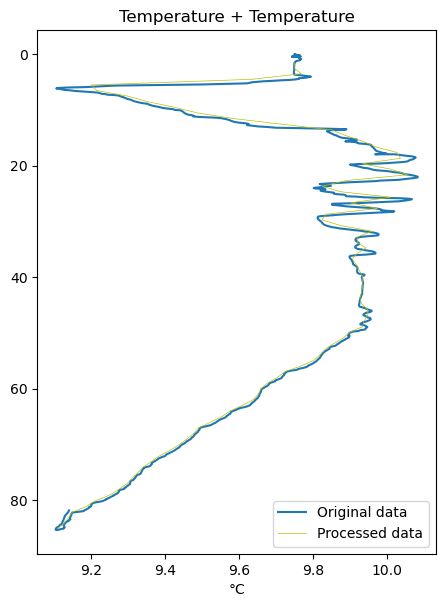

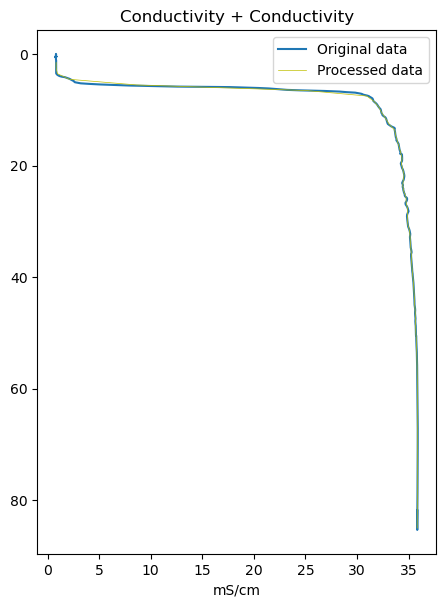

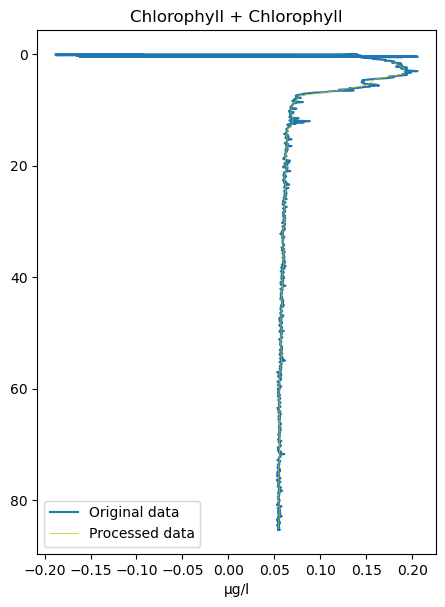

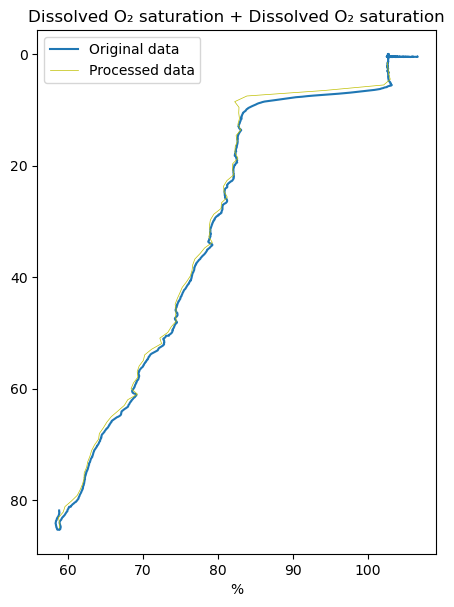

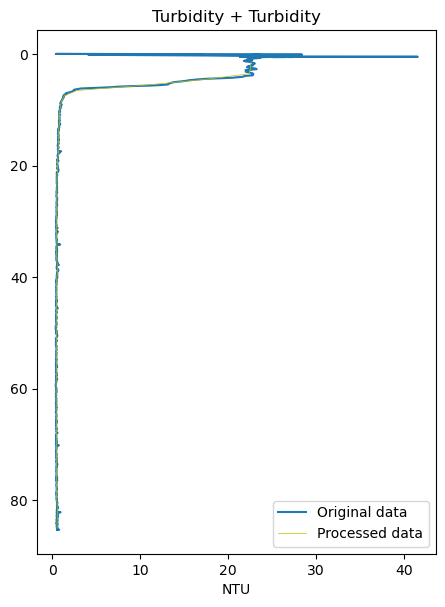

In [23]:
fig1, axes1 = rsk.plotprofiles(channels=['temperature'],profiles=range(1),direction=dir)
fig2, axes2 = raw.plotprofiles(channels=['temperature'],profiles=range(1),direction=dir)

fig, axes = raw.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5,  markerfacecolor = "w",markersize = 4,color="y")
plt.legend(labels=["Original data","Processed data"])

fig1, axes1 = rsk.plotprofiles(channels=['conductivity'],profiles=range(1),direction=dir)
fig2, axes2 = raw.plotprofiles(channels=['conductivity'],profiles=range(1),direction=dir)

fig, axes = raw.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5,  markerfacecolor = "w",markersize = 4,color="y")
plt.legend(labels=["Original data","Processed data"])

fig1, axes1 = rsk.plotprofiles(channels=['chlorophyll'],profiles=range(1),direction=dir)
fig2, axes2 = raw.plotprofiles(channels=['chlorophyll'],profiles=range(1),direction=dir)

fig, axes = raw.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5,  markerfacecolor = "w",markersize = 4,color="y")
plt.legend(labels=["Original data","Processed data"])

fig1, axes1 = rsk.plotprofiles(channels=['dissolved_o2_saturation'],profiles=range(1),direction=dir)
fig2, axes2 = raw.plotprofiles(channels=['dissolved_o2_saturation'],profiles=range(1),direction=dir)

fig, axes = raw.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5,  markerfacecolor = "w",markersize = 4,color="y")
plt.legend(labels=["Original data","Processed data"])

fig1, axes1 = rsk.plotprofiles(channels=['turbidity'],profiles=range(1),direction=dir)
fig2, axes2 = raw.plotprofiles(channels=['turbidity'],profiles=range(1),direction=dir)

fig, axes = raw.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5,  markerfacecolor = "w",markersize = 4,color="y")
plt.legend(labels=["Original data","Processed data"])

## Comparación entre los datos originales y los datos procesados y otros gráficos
### Comparacion datos originales vs procesados
Ejemplo: 

<code>fig1, axes1 = rsk.plotprofiles(channels=["salinity"],profiles=range(1),direction="down")
rsk.binaverage(binSize = 5, boundary = 0.5, direction = "down")
fig2, axes2 = rsk.plotprofiles(channels=["salinity"],profiles=range(1),direction="down")
fig, axes = rsk.mergeplots(
         [fig1,axes1],
         [fig2,axes2],
     )
for ax in axes:
    line = ax.get_lines()[-1]
    plt.setp(line, linewidth=0.5, marker = "o", markerfacecolor = "w")
plt.legend(labels=["Original data","Processed data"])<code/>

### [images](https://docs-static.rbr-global.com/pyrsktools/_rsk/view.html#pyrsktools.RSK.images): 
La visualización 2D puede realizarse usando la función images. Es necesario haber realizado antes binaverage y que ademas el archivo contenga mas de un perfil.

Opcionales:

channels: canal a procesar. [] (default)

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. up, down (default)

reference: canal que será graficado como 'y', puede ser cualquiera. 'sea_preassure' (default)

showgap: graficos interpolados en una grilla de tiempo regular pueden mostrar los gaps entre cada perfil si se elige 'true'. 'true', 'false' (default)

threshold: tiempo límite en segundos para terminar el maximo gap en el grafico. Cualquier gap bajo el limite no sera mostrado. None (default)

image: imagen opcional pre computarizada generada por rsk.generate2D(). None (default)

<code>fig,axes = rsk.images(channels= ["temperature","salinity","turbidity","chlorophyll"],direction="up")<code/>

### [plotdata](https://docs-static.rbr-global.com/pyrsktools/_rsk/view.html#pyrsktools.RSK.plotdata): 
Grafica una serie de tiempo de un canal especifico. El grafico es una serie de tiempo del canal escogido. Si no se especifica un canal se grafican todos

Opcionales:

channels: canal a procesar. [] (default)

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. 'up', 'down' (default)

showcast: muestra la dirección del cast, es recomendable solo en series de tiempo. 'true', 'false' (default)

<code>with RSK("example.rsk") as rsk:
rsk.readdata()
fig, axes = rsk.plotdata(channels=["conductivity", "temperature", "dissolved_o2_saturation", "chlorophyll"])
plt.show()<code/>

### [plotprofiles](https://docs-static.rbr-global.com/pyrsktools/_rsk/view.html#pyrsktools.RSK.plotprofiles): 
Grafica los datos como perfiles, es decir, el canal vs un canal de referencia (sea_pressure por ej).

Opcionales:

channels: canal a procesar. [] (default)

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. 'up', 'down', 'both' (default)

reference: canal que irá en el eje 'y'. 'sea_pressure' (default), 'depth', 'pressure'

<code>with RSK("example.rsk") as rsk:
   rsk.readdata()
   rsk.deriveseapressure()
   rsk.derivesalinity()
   fig, axes = rsk.plotprofiles(
       channels=["conductivity", "temperature", "salinity"],
       profiles=range(0, 3),
       direction="down",
   )
plt.show()<code/>


### [protTS](https://docs-static.rbr-global.com/pyrsktools/_rsk/view.html#pyrsktools.RSK.plotTS): 
Grafica un diagrama TS basado en la salinidad practica y la temperatura potencial (ambas variables deben ser derivadas antes de realizar este grafico).

Opcionales:

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. 'up', 'down', 'both' (default)

isopycnal: cantidad de isopicnas a mostrar. 5 (default)

<code>fig, axes = rsk.plotTS(profiles=range(3), direction="down", isopycnal=10)
plt.show()<code/>


### [plotprocesseddata](https://docs-static.rbr-global.com/pyrsktools/_rsk/view.html#pyrsktools.RSK.plotprocesseddata): 
Grafica un resumen de los datos procesados inicialmente leidos por rsk.readprocesseddata()

Opcionales:

channels: canal a procesar. [] (default)

<code>with RSK("example.rsk") as rsk:
    t1, t2 = np.datetime64("2020-10-03T11:30:00"), np.datetime64("2020-10-03T19:20:00")
    rsk.readdata(t1=t1, t2=t2)
    rsk.readprocesseddata(t1=t1, t2=t2)
    fig, axes = rsk.mergeplots(
        rsk.plotprocesseddata(channels="pressure"),
        rsk.plotdata(channels="pressure"),
    )
    plt.show()<code/>

## Metodos de exportacion

### [RSK2CSV](https://docs-static.rbr-global.com/pyrsktools/_rsk/export.html#pyrsktools.RSK.RSK2CSV):
Crea uno o varios archivos csv a partir de un archivo rsk. Se puede añadir manualmente la ruta de guardado, comentarios, canales y perfiles a extraer a extraer

Opcionales:

channels: canal a procesar. [] (default)

profiles: perfiles a trabajar. [] (default)

direction: direccion del cast. 'up', 'down', 'both' (default)

outputDir: directorio donde se guardaran los archivos. '.' (default), directorio actual

comment: comentarios extra para dejar al final del header del documento. None (default)

<code>with RSK("example.rsk") as rsk:
rsk.computeprofiles()
rsk.RSK2CSV(channels=["conductivity","pressure","dissolved_o2_concentration"], profiles = range(0,3), outputDir="/users/decide/where", comment="My data")<code/>

### [RSK2RSK](https://docs-static.rbr-global.com/pyrsktools/_rsk/export.html#pyrsktools.RSK.RSK2RSK):
Se usa para escribir el actual RSK en un nuevo archivo RSK. Está designado para guardar los datos post-procesados en un archivo SQLite que puede ser leido por Ruskin. El nuevo archivo rsk está en formato "EPdesktop", que es un esquema de tabla más simple de ruskin. Este metodo es conveniente para que usuarios de python puedan facilmente compartir los datos post-procesados con otros sin recurrir a archivos csv, mat u odv.

Opcionales:

outputDir: directorio donde se guardaran los archivos. '.' (default), directorio actual

suffix: palabras que van en la salida del archivo rsk, si no se pone al final del archivo se le agregará la fecha actual en formato YYYYMMDDTHHMM. None (default)

<code>with RSK("example.rsk") as rsk:
rsk.readdata()
rsk.computeprofiles()
outputfilename = rsk.RSK2RSK(outputDir="/users/decide/where", suffix="processed")<code/>


## Otros métodos.

### [create:](https://docs-static.rbr-global.com/pyrsktools/_rsk/other.html#pyrsktools.RSK.create)
Crea un archivo con datos y canales especificados por el usuario como por ejemplo datos de CTD para así aplicar fácilmente las pyRSKtools para post-procesamiento y visualización. Es conveniente cuando se necesita comparar datos de un CTD RBR con otros CTD's.

### [addchannel:](https://docs-static.rbr-global.com/pyrsktools/_rsk/other.html#pyrsktools.RSK.addchannel)
Para agregar nuevos canales con un nombre y unidad de medida definido.

### [removecasts:](https://docs-static.rbr-global.com/pyrsktools/_rsk/other.html#pyrsktools.RSK.removecasts)
Remueve los datos de subida o bajada. Si el archivo solo contiene downcast o upcast la solicitud no tendrá efecto.

### [printchannels:](https://docs-static.rbr-global.com/pyrsktools/_rsk/other.html#pyrsktools.RSK.printchannels)
Despliega la información del instrumento como nombre de canales y unidades de medida.

### [readprocesseddatas](https://docs-static.rbr-global.com/pyrsktools/_rsk/read.html#pyrsktools.RSK.readprocesseddata)
Lee todos los datos o un subset de los datos entre un tiempo1 y un tiempo2 y los escribe en RSK.processedData.
